# Assignment-1 Solution (PDF Learning)
**Student:** Rohan Malhotra  
**Roll Number (r):** 102303437  

This notebook:
- Downloads the Kaggle India Air Quality dataset via `kagglehub`
- Extracts **NO2** as feature **x**
- Computes `z = x + ar*sin(br*x)` for your roll number
- Estimates parameters **λ, μ, c** for:  
$$\hat{p}(z)=c\,e^{-\lambda(z-\mu)^2}$$


In [1]:

# If running on Colab: you may need to install kagglehub first
# !pip -q install kagglehub

import os, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Step 0 — Download dataset via kagglehub

In [2]:

import kagglehub

path = kagglehub.dataset_download("shrutibhargava94/india-air-quality-data")
path


100%|██████████| 5.22M/5.22M [00:00<00:00, 44.9MB/s]

Extracting files...


'/root/.cache/kagglehub/datasets/shrutibhargava94/india-air-quality-data/versions/1'

## Step 0.1 — Set roll number and compute $a_r, b_r$

In [3]:

r = 102303437

ar = 0.05 * (r % 7)
br = 0.3 * ((r % 5) + 1)

r_mod7 = r % 7
r_mod5 = r % 5

r_mod7, r_mod5, ar, br


(5, 2, 0.25, 0.8999999999999999)

## Step 1 — Locate a CSV containing NO2 and load x

In [4]:

data_dir = Path(path)
csvs = sorted(list(data_dir.rglob("*.csv")))
if not csvs:
    raise FileNotFoundError(f"No .csv found under: {data_dir}")

csv_path, no2_col = None, None
for p in csvs:
    try:
        df_head = pd.read_csv(p, nrows=5)
    except Exception:
        continue
    cols = {c.lower(): c for c in df_head.columns}
    if "no2" in cols:
        csv_path, no2_col = p, cols["no2"]
        break

if csv_path is None:
    raise ValueError("Couldn't find a CSV containing a 'NO2' column (case-insensitive).")

csv_path, no2_col


(PosixPath('/root/.cache/kagglehub/datasets/shrutibhargava94/india-air-quality-data/versions/1/data.csv'),
 'no2')

In [6]:
df = pd.read_csv(csv_path, encoding='latin1')
x = pd.to_numeric(df[no2_col], errors="coerce").to_numpy(dtype=float)
x = x[np.isfinite(x)]
x[:10], x.size

/tmp/ipython-input-4081271408.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, encoding='latin1')


(array([17.4,  7. , 28.5, 14.7,  7.5, 25.7, 17.1,  8.7, 23. ,  8.9]), 419509)

## Step 1 — Transform x → z

In [7]:

z = x + ar * np.sin(br * x)
z[:10], z.size


(array([17.41198622,  7.00420348, 28.62362485, 14.853995  ,  7.61251102,
        25.47296169, 17.17815814,  8.94992811, 23.24028818,  9.14696345]),
 419509)

## Step 2 — Estimate parameters (MLE, normalized)
For a proper density:
$$\int_{-\infty}^{\infty} c e^{-\lambda(z-\mu)^2} dz = 1 \Rightarrow c=\sqrt{\lambda/\pi}$$
This corresponds to a Normal distribution with variance $1/(2\lambda)$.
MLE:
- $\mu$ = sample mean of z
- $\sigma^2 = \frac{1}{n}\sum (z-\mu)^2$
- $\lambda = 1/(2\sigma^2)$
- $c = \sqrt{\lambda/\pi}$

In [8]:

mu = float(np.mean(z))
s2 = float(np.mean((z - mu) ** 2))  # MLE variance (divide by n)
lam = 1.0 / (2.0 * s2)
c = math.sqrt(lam / math.pi)

lam, mu, c


(0.0014590905290116402, 25.802708360471062, 0.021550938267777164)

### (Optional) Fit c directly to histogram via least squares

In [9]:

from scipy.optimize import curve_fit

y, edges = np.histogram(z, bins=60, density=True)
centers = 0.5 * (edges[:-1] + edges[1:])

def p_hat(zv, lam_, mu_, c_):
    return c_ * np.exp(-lam_ * (zv - mu_)**2)

p0 = (lam, mu, c)

popt, pcov = curve_fit(p_hat, centers, y, p0=p0, maxfev=20000)
lam_fit, mu_fit, c_fit = popt

(lam_fit, mu_fit, c_fit)


(np.float64(0.0021884980180678247),
 np.float64(20.35219734515719),
 np.float64(0.027219307166871275))

## Plot: Histogram of z and fitted curves

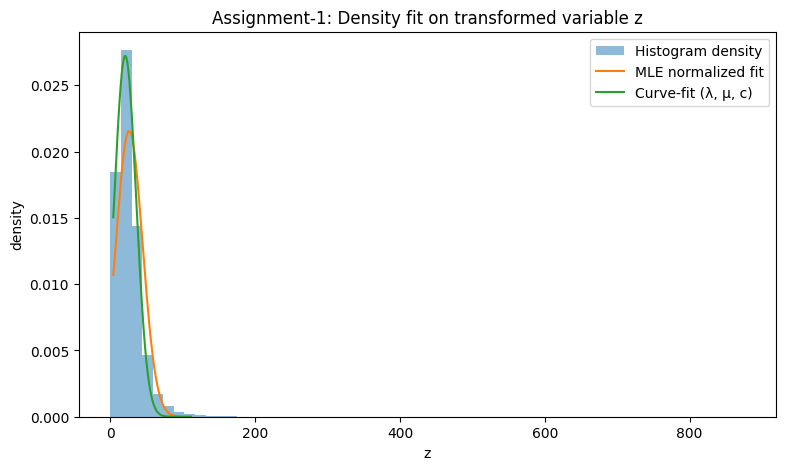

In [10]:

zmin, zmax = np.percentile(z, [0.5, 99.5])
grid = np.linspace(zmin, zmax, 500)

plt.figure(figsize=(9,5))
plt.hist(z, bins=60, density=True, alpha=0.5, label="Histogram density")

plt.plot(grid, c*np.exp(-lam*(grid-mu)**2), label="MLE normalized fit")
plt.plot(grid, c_fit*np.exp(-lam_fit*(grid-mu_fit)**2), label="Curve-fit (λ, μ, c)")

plt.xlabel("z")
plt.ylabel("density")
plt.legend()
plt.title("Assignment-1: Density fit on transformed variable z")
plt.show()


## Step 3 — Final values to submit

In [11]:

print("=== Roll number r =", r, "===")
print(f"ar = {ar:.6f}, br = {br:.6f}")

print("\n--- Normalized MLE ---")
print(f"lambda (λ) = {lam:.10f}")
print(f"mu (μ)     = {mu:.10f}")
print(f"c          = {c:.10f}")

print("\n--- Histogram curve-fit ---")
print(f"lambda (λ) = {lam_fit:.10f}")
print(f"mu (μ)     = {mu_fit:.10f}")
print(f"c          = {c_fit:.10f}")


=== Roll number r = 102303437 ===
ar = 0.250000, br = 0.900000

--- Normalized MLE ---
lambda (λ) = 0.0014590905
mu (μ)     = 25.8027083605
c          = 0.0215509383

--- Histogram curve-fit ---
lambda (λ) = 0.0021884980
mu (μ)     = 20.3521973452
c          = 0.0272193072


## Save results to JSON

In [12]:

import json

results = {
    "student": "Rohan Malhotra",
    "roll_number": r,
    "dataset_path": str(data_dir),
    "csv_used": str(csv_path),
    "no2_column": no2_col,
    "ar": ar,
    "br": br,
    "normalized_mle": {"lambda": lam, "mu": mu, "c": c},
    "hist_curve_fit": {"lambda": float(lam_fit), "mu": float(mu_fit), "c": float(c_fit)},
    "n_points_used": int(z.size),
}

with open("results.json", "w") as f:
    json.dump(results, f, indent=2)

results


{'student': 'Rohan Malhotra',
 'roll_number': 102303437,
 'dataset_path': '/root/.cache/kagglehub/datasets/shrutibhargava94/india-air-quality-data/versions/1',
 'csv_used': '/root/.cache/kagglehub/datasets/shrutibhargava94/india-air-quality-data/versions/1/data.csv',
 'no2_column': 'no2',
 'ar': 0.25,
 'br': 0.8999999999999999,
 'normalized_mle': {'lambda': 0.0014590905290116402,
  'mu': 25.802708360471062,
  'c': 0.021550938267777164},
 'hist_curve_fit': {'lambda': 0.0021884980180678247,
  'mu': 20.35219734515719,
  'c': 0.027219307166871275},
 'n_points_used': 419509}